<a href="https://colab.research.google.com/github/svetaU/DGP/blob/main/two_layer_deep_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An implementation of deep gaussian process with two layers using hamiltonian monte carlo sampling of the full posterior. Inspired by papers and online articles: https://doi.org/10.48550/arxiv.2012.08015 ; https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/ ; https://bayesianbrad.github.io/posts/2019_hmc.html

# Libraries

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as st
import math
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, writers
print(tf.__version__)

2.8.2


# Mount colab drives for data

In [ ]:
import sys, subprocess
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  print("You are in Google Colab environment!")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print("This notebook is best run in Google Colab.")

You are in Google Colab environment!
Mounted at /content/drive


# HMC

In [4]:
def leapfrog(q, p, dUdq, num_steps, step_size, random_step=False,m=None):
  if random_step:
    step_size = np.random.uniform(step_size*0.8,step_size*1.2,1)
  if m is None:
    m = np.ones(len(p))
  q, p = np.copy(q), np.copy(p)
  p -= step_size * dUdq(q) / 2.0  
  leap_path = [np.copy(q)]
  for _ in range(num_steps - 1):
      q += step_size * p/m  
      p -= step_size * dUdq(q) 
      leap_path.append(np.copy(q))
  q += step_size * p/m  
  p -= step_size * dUdq(q) / 2.0
  leap_path.append(np.copy(q)) 
  return (q,-p,leap_path)


In [5]:
def hamiltonian_monte_carlo(U, grad_U, current_position, steps=1, delta_t=0.5, change_step = False, masses = None):
  q = np.copy(current_position)
  p = np.random.normal(0.0,1.0,len(q)) 
  current_momentum = np.copy(p)
  if masses is None:
    masses = np.ones(len(p))
  q, p, path = leapfrog(q,p,grad_U,steps,delta_t,change_step, masses)
  current_U = U(current_position)
  current_K = sum(current_momentum*current_momentum/masses) / 2
  proposed_U = U(q)
  proposed_K = sum(p*p/masses) / 2
  if (np.log(np.random.rand()) < (current_U-proposed_U+current_K-proposed_K)):
    return (q,proposed_U,1,path) # accept
  else:
    return (current_position, current_U,0,None) # reject

# Posterior for Gaussian Process (GP)
The model ($Y_n$ is observed GP, $W_n$ is hidden layer GP of the same dim) 
$$ 
Y_n | W ∼ \mathcal{N}_n(0,\tau^2(K_{\theta_y}(W) +g\mathbb{I}_n)),\;\; W_n \sim \mathcal{N}(0,K_{\theta_w}(X_n)),\;\; K_{\theta}^{ij} = e^{-\frac{||x_i-x_j||^2}{\theta}}
$$

With thus defined probabilities, the log likelihoods are (|A| is determinate of a matrix A)

$$
log \mathcal{L}(Y_n|W,\theta_y,g) \propto - \frac{n}{2}log(n\hat{\tau}^2)-\frac{1}{2}log|K_{\theta_y}(W)+g\mathbb{I}_n|
$$
 
$$
log \mathcal{L}(W|X,\theta_w) \propto -\frac{1}{2}log|K_{\theta_w}(X)| - \frac{1}{2} W^\top K^{-1}_{\theta_w}(X)W
$$

with $\hat{\tau}^2$ is defined as a point estimate (not sampled by MCMC)
$$
\hat{\tau}^2=\frac{Y^\top(K_{\theta_y}(W) + g\mathbb{I}_n)^{-1}Y}{n}
$$
via MLE with reference prior ($1/\tau^2$).

Priors for other hyperparameters are gamma distributions.

Altogether, up to a constant, the posterior for the model params looks like
$$
-log(\pi(W,\vec{\theta},g|D_n)) = -log\mathcal{L}(Y_n|W,\theta_y,g) - log \mathcal{L}(W|X_n,\theta_w) - (a_{\theta_y}-1)log(\theta_y)+b_{\theta_y}\theta_y - (a_{\theta_w}-1)log(\theta_w)+b_{\theta_w}\theta_w - (a_{g}-1)log(g)+b_{g}g
$$

with $D_n$ being the data $(Y_n,X_n)$. Here $a, b$ enter gamma pdf as $p(x;a,b) = \frac{x^{a-1}e^{-bx}b^a}{\Gamma(a)}$

In [6]:
class TLdeepGP():

  def __init__(self, **kwargs):
    self.data = ([],[])
    self.a_ty =3.5
    self.b_ty = 0.8
    self.a_tw =20.1
    self.b_tw = 0.5
    self.a_g =1.5
    self.b_g = 1.5
    self.tau2_mle = 0.

  def set_data(self,data):
    self.data = np.copy(data)
    self.x = tf.convert_to_tensor(self.data[0], dtype=tf.float32)
    self.y = self.data[1]
    self.n = len(self.y)
    self.y = tf.convert_to_tensor(self.y - np.mean(self.y), dtype=tf.float32)

  def log_likelihood(self,params): # -log(p)
  # We should have total (3 + number of points) params that go like (g,theta_w,theta_y,W)
    params = tf.convert_to_tensor(params, dtype=tf.float32)
    noise_matrix = tf.math.multiply(tf.eye(num_rows = self.n,dtype=tf.float32),params[0])
    w = params[3:]
    w_row = tf.expand_dims(w, axis=1)
    w_col = tf.expand_dims(w, axis=0)
    cov_w_matrix = tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(w_row,2) + tf.pow(w_col,2) - 2.*tf.matmul(w_row,w_col)),params[2]))
    cov_w_plus_noise = tf.math.add(cov_w_matrix,noise_matrix)
    det_cov_w_noise = tf.linalg.det(cov_w_plus_noise)
    #inv_cov_w_noise = tfp.math.lu_matrix_inverse(*tf.linalg.lu(cov_w_plus_noise))
    inv_cov_w_noise = tf.linalg.inv(cov_w_plus_noise)
    x_row = tf.expand_dims(self.x, axis=1)
    x_col = tf.expand_dims(self.x, axis=0)
    cov_x_matrix = tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(x_row,2) + tf.pow(x_col,2) - 2.*tf.matmul(x_row,x_col)),params[1]))
    det_cov_x = tf.linalg.det(cov_x_matrix)
    #inv_cov_x = tfp.math.lu_matrix_inverse(*tf.linalg.lu(cov_x_matrix))
    inv_cov_x = tf.linalg.inv(cov_x_matrix)
    tau_2 = tf.linalg.matvec(tf.expand_dims(self.y,axis=0),tf.linalg.matvec(inv_cov_w_noise,self.y),transpose_a=False)
    last_term = tf.divide(tf.linalg.matvec(tf.expand_dims(w,axis=0),tf.linalg.matvec(inv_cov_x,w),transpose_a=False),2.)
    log_likel = tf.math.multiply(-0.5*self.n,tf.math.log(tau_2)) - 0.5*tf.math.log(det_cov_w_noise) \
    - 0.5*tf.math.log(det_cov_x) - last_term
    self.tau2_mle = tau_2/self.n
    return -log_likel   

  def log_priors(self,params): # -log(\pi)
    p_params = - (self.a_g - 1.0)*math.log(params[0]) + self.b_g*params[0] \
    - (self.a_tw - 1.0)*math.log(params[1]) + self.b_tw*params[1] \
    - (self.a_ty - 1.0)*math.log(params[2]) + self.b_ty*params[2] 
    return p_params

  def log_likelihood_grad(self,params): 
    params = tf.convert_to_tensor(params, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(params)
      y = self.log_likelihood(params)
    return tape.gradient(y,params)

  def log_priors_grad(self, params):
    p_params_grad = np.zeros(3 + self.n)
    p_params_grad[0] = - (self.a_g - 1.0)/params[0] + self.b_g
    p_params_grad[1] = - (self.a_tw - 1.0)/params[1] + self.b_tw
    p_params_grad[2] = - (self.a_ty - 1.0)/params[2] + self.b_ty
    return p_params_grad

  def log_prob(self, params):
    return self.log_likelihood(params).numpy() + self.log_priors(params)

  def log_prob_grad(self,params):
    return self.log_likelihood_grad(params).numpy() + self.log_priors_grad(params)

  def kriging_w(self,params,new_locations):
    params = tf.convert_to_tensor(params, dtype=tf.float32)
    new_x_row = tf.expand_dims(tf.convert_to_tensor(new_locations, dtype=tf.float32), axis=1)
    new_x_col = tf.expand_dims(tf.convert_to_tensor(new_locations, dtype=tf.float32), axis=0)
    old_x_col = tf.expand_dims(self.x, axis=0)
    old_x_row = tf.expand_dims(self.x, axis=1)
    w = params[3:]
    cross_cov_x_matrix = tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(new_x_row,2) + tf.pow(old_x_col,2) - 2.*tf.matmul(new_x_row,old_x_col)),params[1]))
    cov_x_matrix = tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(old_x_col,2) + tf.pow(old_x_row,2) - 2.*tf.matmul(old_x_row,old_x_col)),params[1]))
    cov_new_x_matrix = tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(new_x_col,2) + tf.pow(new_x_row,2) - 2.*tf.matmul(new_x_row,new_x_col)),params[1]))
    inv_cov_x = tf.linalg.inv(cov_x_matrix)
    mu_w = tf.linalg.matvec(cross_cov_x_matrix,tf.linalg.matvec(inv_cov_x,w))
    sigma_w = cov_new_x_matrix - tf.matmul(cross_cov_x_matrix,tf.matmul(inv_cov_x,tf.transpose(cross_cov_x_matrix)))
    return (mu_w.numpy(),sigma_w.numpy())

  def kriging_y(self,params,tau2,new_w):
    new_n = len(new_w)
    new_w = tf.convert_to_tensor(new_w, dtype=tf.float32)
    params = tf.convert_to_tensor(params, dtype=tf.float32)
    w = params[3:]
    new_w_row = tf.expand_dims(new_w, axis=1)
    new_w_col = tf.expand_dims(new_w, axis=0)
    w_row = tf.expand_dims(w, axis=1)
    w_col = tf.expand_dims(w, axis=0)
    cross_cov_w_matrix = tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(new_w_row,2) + tf.pow(w_col,2) - 2.*tf.matmul(new_w_row,w_col)),params[2]))
    cov_w_matrix =  tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(w_row,2) + tf.pow(w_col,2) - 2.*tf.matmul(w_row,w_col)),params[2]))
    cov_new_w_matrix =  tf.math.exp(-tf.math.divide(tf.maximum(0.,tf.pow(new_w_row,2) + tf.pow(new_w_col,2) - 2.*tf.matmul(new_w_row,new_w_col)),params[2]))
    noise_matrix = tf.math.multiply(tf.eye(num_rows = self.n,dtype=tf.float32),params[0])
    noise_matrix_new = tf.math.multiply(tf.eye(num_rows = new_n,dtype=tf.float32),params[0])
    inv_cov_w_noise = tf.linalg.inv(tf.math.add(cov_w_matrix,noise_matrix))
    cov_new_w_plus_new_noise = tf.math.add(cov_new_w_matrix,noise_matrix_new)
    mu_y = tf.linalg.matvec(cross_cov_w_matrix,tf.linalg.matvec(inv_cov_w_noise,self.y))
    sigma_y = tf.math.multiply(tau2,cov_new_w_plus_new_noise - tf.matmul(cross_cov_w_matrix,tf.matmul(inv_cov_w_noise,tf.transpose(cross_cov_w_matrix))))
    return (mu_y.numpy(),sigma_y.numpy())


# Fit parameters

In [9]:
def fit_dgp_w_hmc():
  num_points = 20
  points_to_sim = 300
  target_mean = np.zeros(num_points)
  target_mean[8] = 2.
  target_mean[9] = 2.
  target_mean[10] = 2.
  target_cov = np.eye(num_points) 
  for i in range(num_points-1):
    target_cov[i+1,i] = target_cov[i,i+1] = 0.1
  sample_size = int(points_to_sim/5)
  data_sample_y = 2.*np.random.multivariate_normal(target_mean,target_cov,size=sample_size).T
  mean_data_sample_y = np.mean(np.array(data_sample_y),axis=1)
  data_sample_x = np.linspace(0,100,num_points)
  noise = np.random.normal(0.,1.,num_points)
  for i in range(1,sample_size):
    plt.plot(data_sample_x,data_sample_y[:,i],linestyle='dashed', linewidth=1,alpha=0.5)
  plt.plot(data_sample_x,data_sample_y[:,0], c='b')
  plt.scatter(data_sample_x,data_sample_y[:,0] + noise, c='b')
  plt.plot(data_sample_x,mean_data_sample_y, c='black')
  plt.show()
  model_fit = TLdeepGP()
  model_fit.set_data((np.squeeze(data_sample_x),np.squeeze(data_sample_y[:,0] + noise)))
  l_steps = 50
  burn = 0
  burn2 = 100
  hmc_steps = np.asarray(range(points_to_sim+1-burn))
  m = np.ones(num_points + 3,dtype=np.float32)
  m[0] = 80.
  m[1] = 10.
  m[2] = 20.
  sim_dots = []
  q = np.ones(num_points + 3,dtype=np.float32)
  q[0] = 0.5
  q[1] = 30.
  q[2] = 20.
  sim_dots.append(q)
  paths = []
  energy = []
  tau2 = []
  accept_rate = 0
  for i in range(points_to_sim):
    q, orbit,accept,l_path = hamiltonian_monte_carlo(model_fit.log_prob,model_fit.log_prob_grad,q,steps=l_steps, \
                                                     delta_t=0.07,masses=m)
    sim_dots.append(q)
    tau2.append(model_fit.tau2_mle)
    energy.append(orbit)
    paths.append(l_path)
    accept_rate = accept_rate + accept
  print("Acceptance rate " + str(accept_rate/points_to_sim))
  for point in sim_dots[burn:points_to_sim]:
    plt.scatter(point[1],point[2],c='red',s=30)
  for path in paths[burn:points_to_sim]:
    if path is not None:
      plt.plot(np.asarray(path)[:,1],np.asarray(path)[:,2], c='black')
  plt.title("Correlation length")
  plt.xlabel("theta_w")
  plt.ylabel("theta_y")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,0])
  plt.title("Trace plot g")
  plt.xlabel("iteration")
  plt.ylabel("g")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,1])
  plt.title("Trace plot theta_w")
  plt.xlabel("iteration")
  plt.ylabel("theta_w")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,2])
  plt.title("Trace plot theta_y")
  plt.xlabel("iteration")
  plt.ylabel("theta_y")  
  plt.show()
  plt.scatter(hmc_steps[1:],np.asarray(tau2)[burn:])
  plt.title("Trace plot tau2")
  plt.xlabel("iteration")
  plt.ylabel("tau2")  
  plt.show()
  plt.scatter(hmc_steps[1:],np.asarray(energy)[burn:])
  plt.title("Trace plot H")
  plt.xlabel("iteration")
  plt.ylabel("H")  
  plt.show()
  i = 0
  for hidden_layer in sim_dots[burn2:]:
    w = hidden_layer[3:]
    i = i + 1
    if i%10 == 0:
      plt.plot(np.squeeze(data_sample_x),w)
  return model_fit,(sim_dots,tau2), mean_data_sample_y

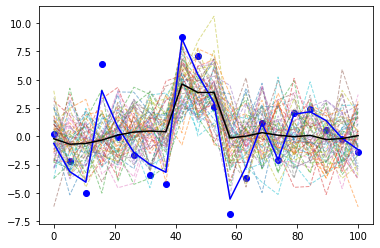

Acceptance rate 0.99


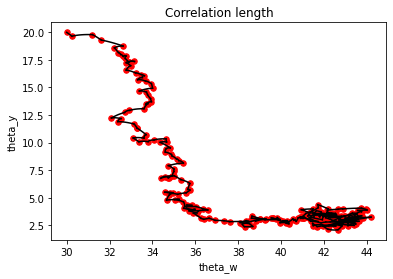

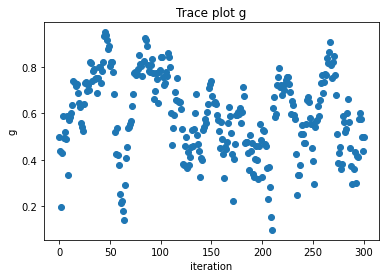

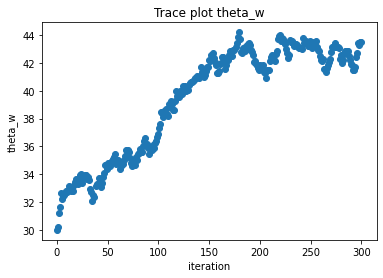

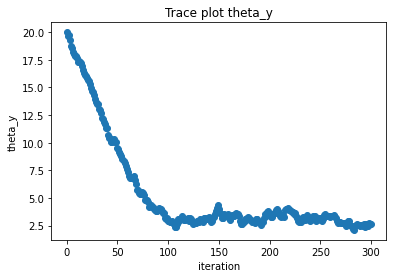

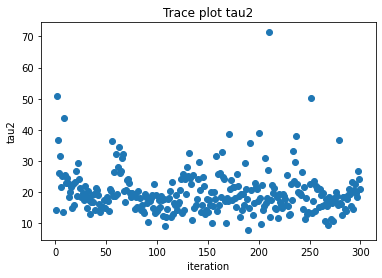

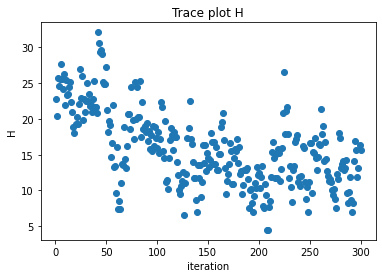

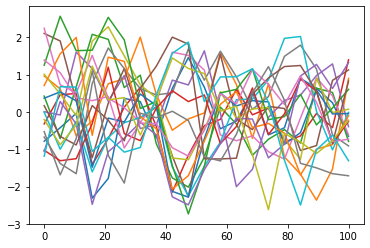

In [11]:
model,sim_dots,mean_y = fit_dgp_w_hmc()

# Infer data

In [14]:
def predict_w_gdp(model_fit,fit_params,mean_data):
  predict_points = 100
  data_predict_x = np.linspace(0.,100.,predict_points)
  predicted_y = []
  (params, tau2s) = fit_params
  num_iter = len(tau2s)
  burn = 150
  noise = 0.
  for param, tau2 in zip(params[(burn + 1):],tau2s[burn:]):
    noise = noise + param[0]*tau2
    mu_w, sigma_w = model_fit.kriging_w(param,data_predict_x)
    w = np.random.multivariate_normal(mu_w,sigma_w,size=1).T
    mu_y, sigma_y = model_fit.kriging_y(param,tau2,w[:,0])
    predicted_y.append(mu_y)
  noise = noise/(num_iter - burn)
  mu_predicted_y = np.mean(np.array(predicted_y),axis=0)
  cov_predicted_y = np.cov(np.array(predicted_y),rowvar=False) - noise*np.eye(predict_points)
  predicted_sample_y = np.random.multivariate_normal(mu_predicted_y,cov_predicted_y,size=20).T
  for i in range(1,20):
    plt.plot(data_predict_x,predicted_sample_y[:,i],c='grey',linestyle='dashed', linewidth=1,alpha=0.5)
  plt.plot(data_predict_x,mu_predicted_y)
  plt.plot(model.x,mean_data,c='red')
  plt.plot(model.x,model.y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not positive-semidefinite.


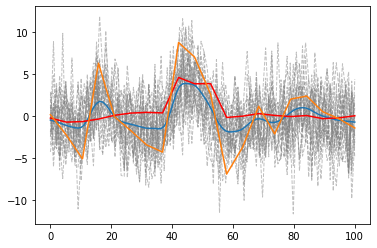

In [15]:
predict_w_gdp(model,sim_dots,mean_y)